In [34]:
import numpy as np
import matplotlib.pyplot as plt

class BernoulliBandit:
    """ 伯努利多臂老虎机, 输入K表示拉杆个数 """
    def __init__(self, K):
        self.probs = np.random.uniform(size=K) # 随机生成K个0~1的数

        self.best_idx = np.argmax(self.probs) # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx] # 最大获奖概率
        self.K = K

    def step(self, k):
        """ 拉第k个拉杆, 返回奖励0或1 """
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0
        
np.random.seed(1) # 固定随机数种子, 使得每次运行结果相同
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂老虎机, 各拉杆的获奖概率为:" % K)
print("获奖概率最大的拉杆是第%d个, 获奖概率为%.4f" % (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个10臂老虎机, 各拉杆的获奖概率为:
获奖概率最大的拉杆是第1个, 获奖概率为0.7203


In [35]:
class Solver:
    """多臂老虎机算法基本框架"""
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(bandit.K) # 记录每个拉杆被拉的次数
        self.regret = 0 # 当前步的累计懊悔
        self.actions = [] # 维护一个列表，记录每一步选择的拉杆
        self.regrets = [] # 维护一个列表，记录每一步的累计懊悔

    def update_regret(self, k):
        """ 计算累积懊悔并保存, k为本次动作选择的拉杆"""
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        """ 返回当前运动选择哪一根拉杆, k为本次选择的拉杆 """
        # k = self._select_arm() # 选择一根拉杆
        # reward = self.bandit.step(k) # 拉动拉杆, 获得奖励
        # self.counts[k] += 1 # 更新被拉动的拉杆的计数
        # self.actions.append(k) # 记录本次选择的拉杆
        # self.update_regret(k) # 更新累计懊悔
        # return k
        raise NotImplementedError

    def run(self, num_steps):
        """ 运行num_steps步 """
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

class EpsilonGreedy(Solver):
    """ ε-贪婪算法 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon # ε的值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1 * (r - self.estimates[k]))
        return k


episilon-贪婪算法的累积懊悔为： 21.11182682064292


C:\Users\Thomas Wong\AppData\Local\Temp\ipykernel_30488\3407042337.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  self.estimates[k] += 1. / (self.counts[k] + 1 * (r - self.estimates[k]))


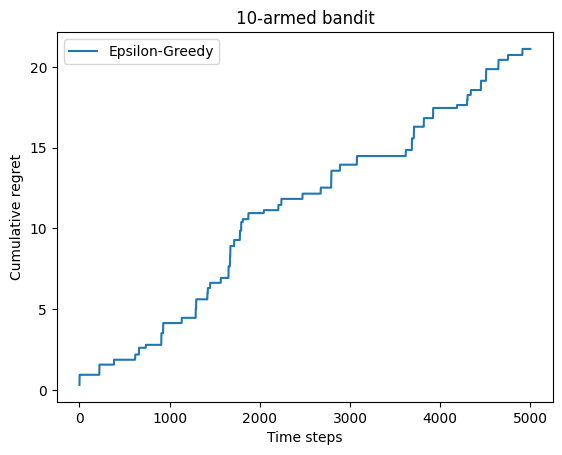

In [36]:
def plot_results(solvers, solver_names):
    """ 生成累积懊悔曲线随时间变化的图像。输入solvers是一个列表， 列表中的每一个元素是一种
    特定的策略。而solver_names也是一个列表，存储每个策略的名称。 """
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regret')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

np.random.seed(1) # 固定随机数种子, 使得每次运行结果相同
episilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
episilon_greedy_solver.run(5000)
print('episilon-贪婪算法的累积懊悔为：', episilon_greedy_solver.regret)
plot_results([episilon_greedy_solver], ['Epsilon-Greedy'])

C:\Users\Thomas Wong\AppData\Local\Temp\ipykernel_30488\3407042337.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  self.estimates[k] += 1. / (self.counts[k] + 1 * (r - self.estimates[k]))


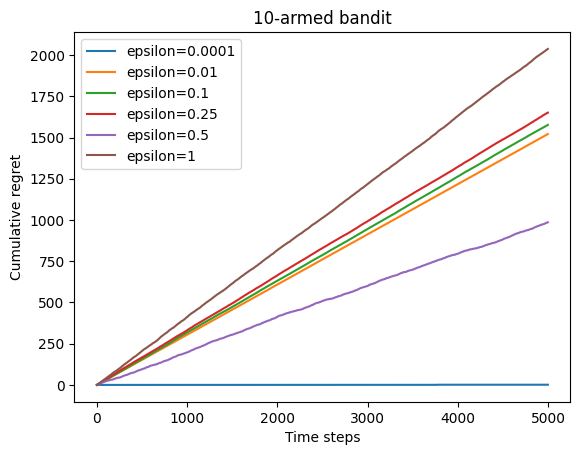

In [37]:
np.random.seed(0)
episilons = [0.0001, 0.01, 0.1, 0.25, 0.5, 1]
episilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in episilons
]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in episilons]
for solver in episilon_greedy_solver_list:
    solver.run(5000)
    
plot_results(episilon_greedy_solver_list, epsilon_greedy_solver_names)


epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183


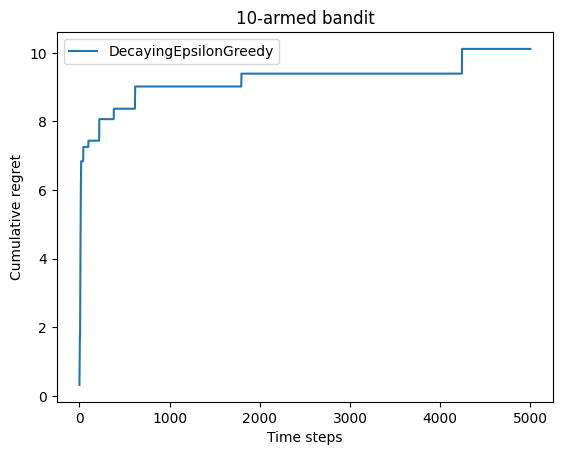

In [38]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

UCB算法的累积懊悔为： 70.45281214197854


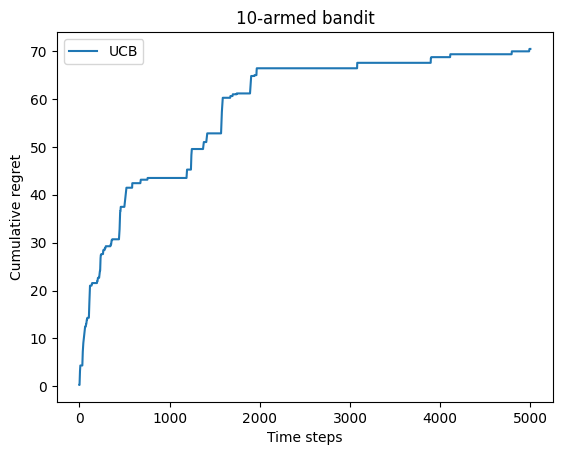

In [39]:
class UCB(Solver):
    """ UCB算法, 继承Solver类 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2* (self.counts + 1)))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k
    
np.random.seed(1)
coef = 1 # 控制探索程度的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('UCB算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ['UCB'])

汤普森采样算法的累积懊悔为： 57.19161964443925


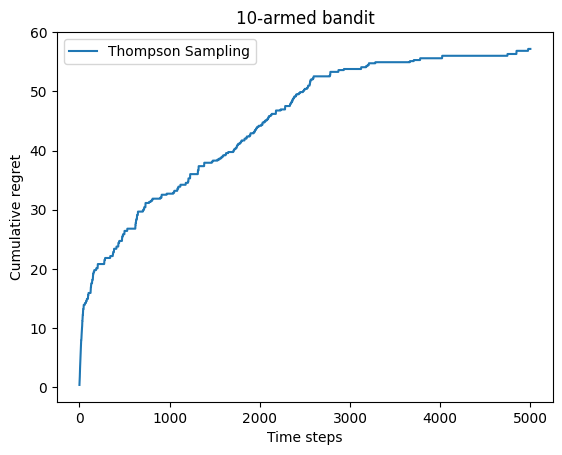

In [40]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法, 继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(bandit.K) # 记录每个拉杆获得奖励1的次数
        self._b = np.ones(bandit.K) # 记录每个拉杆获得奖励0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)
        k = np.argmax(samples)
        r = self.bandit.step(k)

        self._a[k] += r
        self._b[k] += 1 - r
        return k
    
np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ['Thompson Sampling'])